In [ ]:
!pip install tensorflow-gpu==2.10.0

In [4]:
!conda install numpy pandas scikit-learn matplotlib

^C


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt # Импортируем matplotlib для графика
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
class LMU(layers.Layer):
    def __init__(self, units, activation='tanh', return_sequences=False, **kwargs):
        super(LMU, self).__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)
        self.return_sequences = return_sequences

    def build(self, input_shape):
        self.W_x = self.add_weight(name="W_x", shape=(input_shape[-1], self.units),
                                  initializer='glorot_uniform',
                                  trainable=True)
        self.W_h = self.add_weight(name="W_h", shape=(self.units, self.units),
                                  initializer='glorot_uniform',
                                  trainable=True)
        #  Исправляем  размерность  W_h_t
        self.W_h_t = self.add_weight(name="W_h_t", shape=(self.units, input_shape[-1]),
                                  initializer='glorot_uniform',
                                  trainable=True)
        self.b = self.add_weight(name="b", shape=(self.units,),
                                  initializer='zeros',
                                  trainable=True)

    def call(self, inputs):
        #  Транспонируем  self.W_x  здесь
        W_x_t = keras.backend.transpose(self.W_x)
        #  Не  транспонируем  self.W_h_t  здесь
        # W_h_t_t = keras.backend.transpose(self.W_h_t)

        f = keras.backend.sigmoid(keras.backend.dot(inputs, W_x_t) + keras.backend.dot(inputs, self.W_h_t) + self.b)
        g = self.activation(keras.backend.dot(inputs, W_x_t) + keras.backend.dot(inputs, self.W_h_t) + self.b)
        h = f * g + (1 - f) * inputs

        if self.return_sequences:
            return h
        else:
            return h[:, -1, :]

    def get_config(self):
        config = super(LMU, self).get_config()
        config.update({
            "units": self.units,
            "activation": keras.activations.serialize(self.activation),
            "return_sequences": self.return_sequences
        })
        return config

Epoch 1/10
6513/6513 [==============================] - 2247s 344ms/step - loss: 0.9828 - accuracy: 0.6537 - val_loss: 0.6973 - val_accuracy: 0.7745
Epoch 2/10
6513/6513 [==============================] - 2246s 345ms/step - loss: 0.5556 - accuracy: 0.8148 - val_loss: 0.3937 - val_accuracy: 0.8698
Epoch 3/10
6513/6513 [==============================] - 2246s 345ms/step - loss: 0.4794 - accuracy: 0.8429 - val_loss: 0.5656 - val_accuracy: 0.8107
Epoch 4/10
6513/6513 [==============================] - 2249s 345ms/step - loss: 0.4362 - accuracy: 0.8550 - val_loss: 0.3649 - val_accuracy: 0.8753
Epoch 5/10
6513/6513 [==============================] - 2261s 347ms/step - loss: 0.3510 - accuracy: 0.8783 - val_loss: 0.2737 - val_accuracy: 0.9016
Epoch 6/10
6513/6513 [==============================] - 2251s 346ms/step - loss: 0.3099 - accuracy: 0.8872 - val_loss: 0.2648 - val_accuracy: 0.9044
Epoch 7/10
6513/6513 [==============================] - 2255s 346ms/step - loss: 0.3577 - accuracy: 0.8710

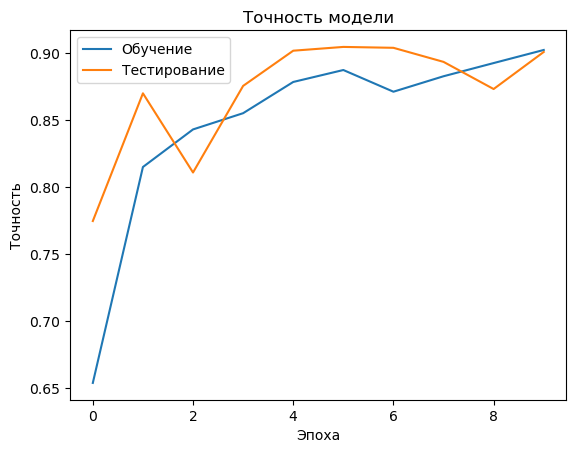

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt # Импортируем matplotlib для графика
from tensorflow.keras.callbacks import EarlyStopping

# Путь к датасету
dataset_folder = './data/'
dataset_name = 'emotions.csv'

# Загрузка данных
splits = {'train': dataset_name, 'validation': dataset_name, 'test': dataset_name}
df_train = pd.read_csv(dataset_folder + splits["train"])
df_val = pd.read_csv(dataset_folder + splits["validation"])
df_test = pd.read_csv(dataset_folder + splits["test"])

# Преобразование данных
x_train = df_train['text'].values
y_train = df_train['label'].values
x_val = df_val['text'].values
y_val = df_val['label'].values
x_test = df_test['text'].values
y_test = df_test['label'].values

# Токенизация
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(x_train)

# Определение vocab_size
vocab_size = len(tokenizer.word_index) + 1

x_train = tokenizer.texts_to_sequences(x_train)
x_val = tokenizer.texts_to_sequences(x_val)
x_test = tokenizer.texts_to_sequences(x_test)

# Создание  последовательностей  фиксированной  длины
maxlen = 200
x_train = pad_sequences(x_train, maxlen=maxlen)
x_val = pad_sequences(x_val, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

# Загружаем предобученные embeddings (например, GloVe)
embeddings_index = {}
embeddings_path = './embeddings/glove.6B.100d.txt'
with open(embeddings_path, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Создаем матрицу embeddings
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Определяем количество классов
num_classes = len(np.unique(y_train))

# Обновление модели
model = Sequential([
    Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False),
    SimpleRNN(256, return_sequences=True),
    Dropout(0.2),
    SimpleRNN(128),
    Dense(num_classes, activation='softmax')  # Обновленный выходной слой для многоклассовой классификации
])

# Компиляция модели
optimizer = RMSprop(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) # Добавлено early stopping


# Обучение модели
history = model.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=64,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping]
)

# Оценка модели
loss, accuracy = model.evaluate(x_test, y_test)
print('Точность: {}'.format(accuracy))

# Визуализация графика обучения
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Точность модели')
plt.ylabel('Точность')
plt.xlabel('Эпоха')
plt.legend(['Обучение', 'Тестирование'], loc='upper left')
plt.show()


In [2]:
print("Пример обучающих данных после токенизации:", x_train[:5])
print("Пример меток:", y_train[:5])
print("Размеры x_train:", x_train.shape)


Пример обучающих данных после токенизации: [[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0

In [11]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# Функция для предсказания эмоций
def predict_emotion(text, model, tokenizer, maxlen):
    """Предсказывает эмоцию для данного текста.

    Args:
        text: Строка, содержащая текст.
        model: Обученная модель.
        tokenizer: Токенизатор, использованный для обучения модели.
        maxlen: Максимальная длина последовательности, используемая при обучении.

    Returns:
        Предсказанная эмоция (0 - sadness, 1 - joy, 2 - love, 3 - anger, 4 - fear, 5 - surprise).
    """

    # Токенизация текста
    sequence = tokenizer.texts_to_sequences([text])

    # Padding последовательности
    padded_sequence = pad_sequences(sequence, maxlen=maxlen)

    # Предсказание эмоции
    prediction = model.predict(padded_sequence)
    
    # Вывод предсказанных вероятностей
    print("Предсказанные вероятности:", prediction)
    
    # Преобразование вероятностей в класс
    emotion = np.argmax(prediction, axis=1)[0]


    return emotion

if __name__ == "__main__":
    maxlen = 150
    loaded_model = keras.models.load_model("./results/final_model.h5")

    new_text = "i like this"
    predicted_emotion = predict_emotion(new_text, loaded_model, tokenizer, maxlen)

    emotions = ["sadness", "joy", "love", "anger", "fear", "surprise"]
    print(new_text)
    print(f"Предсказанная эмоция: {emotions[predicted_emotion]}")


1/1 [==============================] - 0s 144ms/step
Предсказанные вероятности: [[1.]]
i like this
Предсказанная эмоция: sadness
